In [1]:
%matplotlib inline
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
import numpy as np
import warnings

from pint import UnitRegistry
ureg=UnitRegistry()
si=lambda x: ureg(x).to_base_units().magnitude
from pynitride.compact.models import GaNHEMT_iMVSG,VO2Res,HyperFET

In [40]:
# Shukla given parameters

# Table
rho_m=si("5e-4 ohm cm")
rho_i=si("80 ohm cm")
J_MIT=si("2e6 A/cm^2") # SAMMMM
J_IMT=si(".55e4 A/cm^2")

# Text
thickness=si("14nm")
vo2W=si("14nm")
vo2L=si("8nm")

In [41]:
def VO2(W,L):
    I_IMT=J_IMT*thickness*W
    I_MIT=J_MIT*thickness*W
    
    R_ins=rho_i*L/(W*thickness)
    R_met=rho_m*L/(W*thickness)
    
    V_IMT=I_IMT*R_ins
    V_MIT=I_MIT*R_met
    
    return VO2Res(I_IMT=I_IMT, V_IMT=V_IMT, I_MIT=I_MIT, V_MIT=V_MIT, R_met=R_met)


In [42]:
GaNHEMT_iMVSG(VT0=-5).shifted(3).VT0

-2.0

In [43]:
VO2(vo2W,vo2L).I_IMT/50e-9

0.21560000000000004

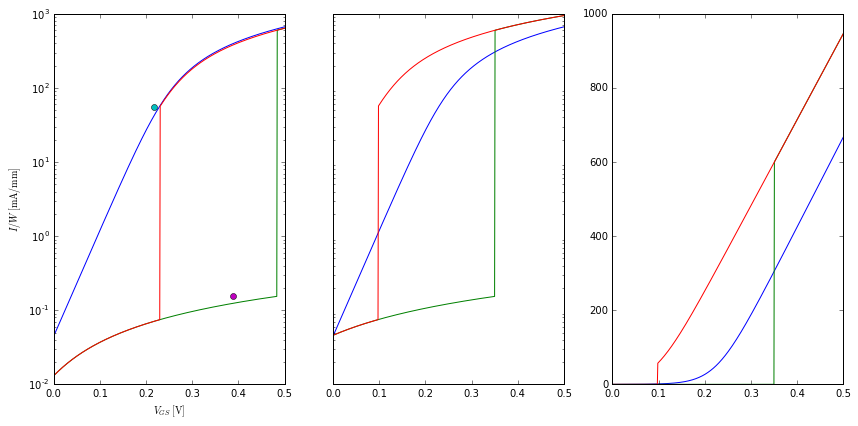

In [45]:
@interact(VT0=FloatSlider(value=.23,min=0,max=1,step=.05,continuous_update=False),
          W=FloatSlider(value=70,min=10,max=100,step=10,continuous_update=False),
          Cinv_vxo=FloatSlider(value=2500,min=1000,max=5000,step=400,continuous_update=False),
          SS=FloatSlider(value=.070,min=.05,max=.09,step=.005,continuous_update=False),
          alpha=FloatSlider(value=0,min=0,max=5,step=.5,continuous_update=False),
          beta=FloatSlider(value=1.8,min=0,max=4,step=.1,continuous_update=False),
          VDD=FloatSlider(value=.5,min=.3,max=1,step=.05,continuous_update=False),
          VDsats=FloatSlider(value=.1,min=.1,max=2,step=.1,continuous_update=False),
          delta=FloatSlider(value=0,min=0,max=.5,step=.1,continuous_update=False),
          log10Gleak=FloatSlider(value=-12,min=-14,max=-5,step=1,continuous_update=False),
          #vo2W=FloatSlider(value=-12,min=-14,max=-5,step=1,continuous_update=False),
         )
def show_HyperFET(VT0,W,Cinv_vxo,SS,alpha,beta,VDsats,VDD,delta,log10Gleak):#,vo2W,vo2L):
    
    plt.figure(figsize=(12,6))
    hemt=GaNHEMT_iMVSG(
        W=W*1e-9,Cinv_vxo=Cinv_vxo,
        VT0=VT0,alpha=alpha,SS=SS,delta=delta,
        VDsats=VDsats,beta=beta,eta=0,Gleak=10**log10Gleak)
    
    vo2=VO2(vo2W,vo2L)
    hf=HyperFET(hemt,vo2,VDD)
    #print(HyperFET.approx_shift(hemt,vo2))
    hemt2=hemt.shifted(hf.approx_shift())
    hf2=HyperFET(hemt2,vo2,VDD)
    
    VD=np.array(VDD)
    VG=np.linspace(0,.5,500)

    plt.subplot(131)
    I=hemt.ID(VD=VD,VG=VG)
    plt.plot(VG,I/hemt.W)
    
    
    If,Ib=[np.ravel(i) for i in hf.I_double(VD=VD,VG=VG)]
    plt.plot(VG[~np.isnan(If)],If[~np.isnan(If)]/hemt.W)
    plt.plot(VG[~np.isnan(Ib)],Ib[~np.isnan(Ib)]/hemt.W)
    
    plt.plot(hf.approx_hyst("Vleft"),vo2.I_MIT/hemt.W,'o')
    plt.plot(hf.approx_hyst("Vright"),vo2.I_IMT/hemt.W,'o')
    
    
    floor=10**log10Gleak*VD
    
    # Because yscale log complains about NaNs
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        plt.yscale('log')
        plt.ylim(1e-2,1e3)
        plt.xlabel("$V_{GS}\;\mathrm{[V]}$")
        plt.ylabel("$I/W\;\mathrm{[mA/mm]}$")
        
    
    
    plt.subplot(132)
    I=hemt.ID(VD=VD,VG=VG)    
    plt.plot(VG,I/hemt2.W)
    If,Ib=[np.ravel(i) for i in hf2.I_double(VD=VD,VG=VG)]
    plt.plot(VG[~np.isnan(If)],If[~np.isnan(If)]/hemt2.W)
    plt.plot(VG[~np.isnan(Ib)],Ib[~np.isnan(Ib)]/hemt2.W)
    
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        plt.yscale('log')
        plt.ylim(1e-2,1e3)
        #plt.xlabel("$V_{GS}\;\mathrm{[V]}$")
        #plt.ylabel("$I/W\;\mathrm{[mA/mm]}$")
        plt.yticks([])
        
    plt.subplot(133)
    I=hemt.ID(VD=VD,VG=VG)    
    plt.plot(VG,I/hemt2.W)
    If,Ib=[np.ravel(i) for i in hf2.I_double(VD=VD,VG=VG)]
    plt.plot(VG[~np.isnan(If)],If[~np.isnan(If)]/hemt2.W)
    plt.plot(VG[~np.isnan(Ib)],Ib[~np.isnan(Ib)]/hemt2.W)
        
    plt.tight_layout()

In [39]:
from scipy.special import lambertw

In [8]:
(lambda x: lambertw(x)/(np.log(x/np.log(x))))(10)

(1.1886043073904817+0j)